## **Pairwise HPO Correlation Analysis Workflow**

This notebook demonstrates how to load phenopacket data, generate HPO matrices, and disease target vectors, and perform correlation analyses using the `ppkt2synergy` package. The workflow covers steps from data loading to statistical testing and visualization.

---

### **Install Dependencies**

To get started, ensure you have the required libraries installed. Run the following command in your terminal or command prompt to install `ppkt2synergy` and `gpsea`:

```bash
pip install ppkt2synergy gpsea



### **Import Libraries**
Once the dependencies are installed, import the necessary libraries to begin your analysis:

In [1]:
from ppkt2synergy import CohortDataLoader, HPOStatisticsAnalyzer,PhenopacketMatrixProcessor
from gpsea.model import VariantEffect

### **Analysis of Correlation for Terms from a Single Cohort**

This section demonstrates how to perform correlation analysis for HPO terms, disease status, sex, and variant effects in a single cohort.

---

##### **Loading Data and Preparing HPO Matrices**

In [2]:
cohort_name = "FBN1"
mane_tx_id = 'NM_000138.5'  # Can be None
variant_effect_type = VariantEffect.MISSENSE_VARIANT  # Can be None

phenopackets = CohortDataLoader.from_ppkt_store(cohort_name=cohort_name)
hpo_matrix, target_matrix = PhenopacketMatrixProcessor.prepare_hpo_data(
    variant_effect_type=variant_effect_type,
    mane_tx_id=mane_tx_id, 
    phenopackets=phenopackets, 
    threshold=0, 
    mode=None, 
    use_label=True,
    nan_strategy=None)

Individuals Processed: 100%|██████████| 144/144 [00:01<00:00, 86.72 individuals/s]


##### **Analysusing Data and Ploting the Heatmap**

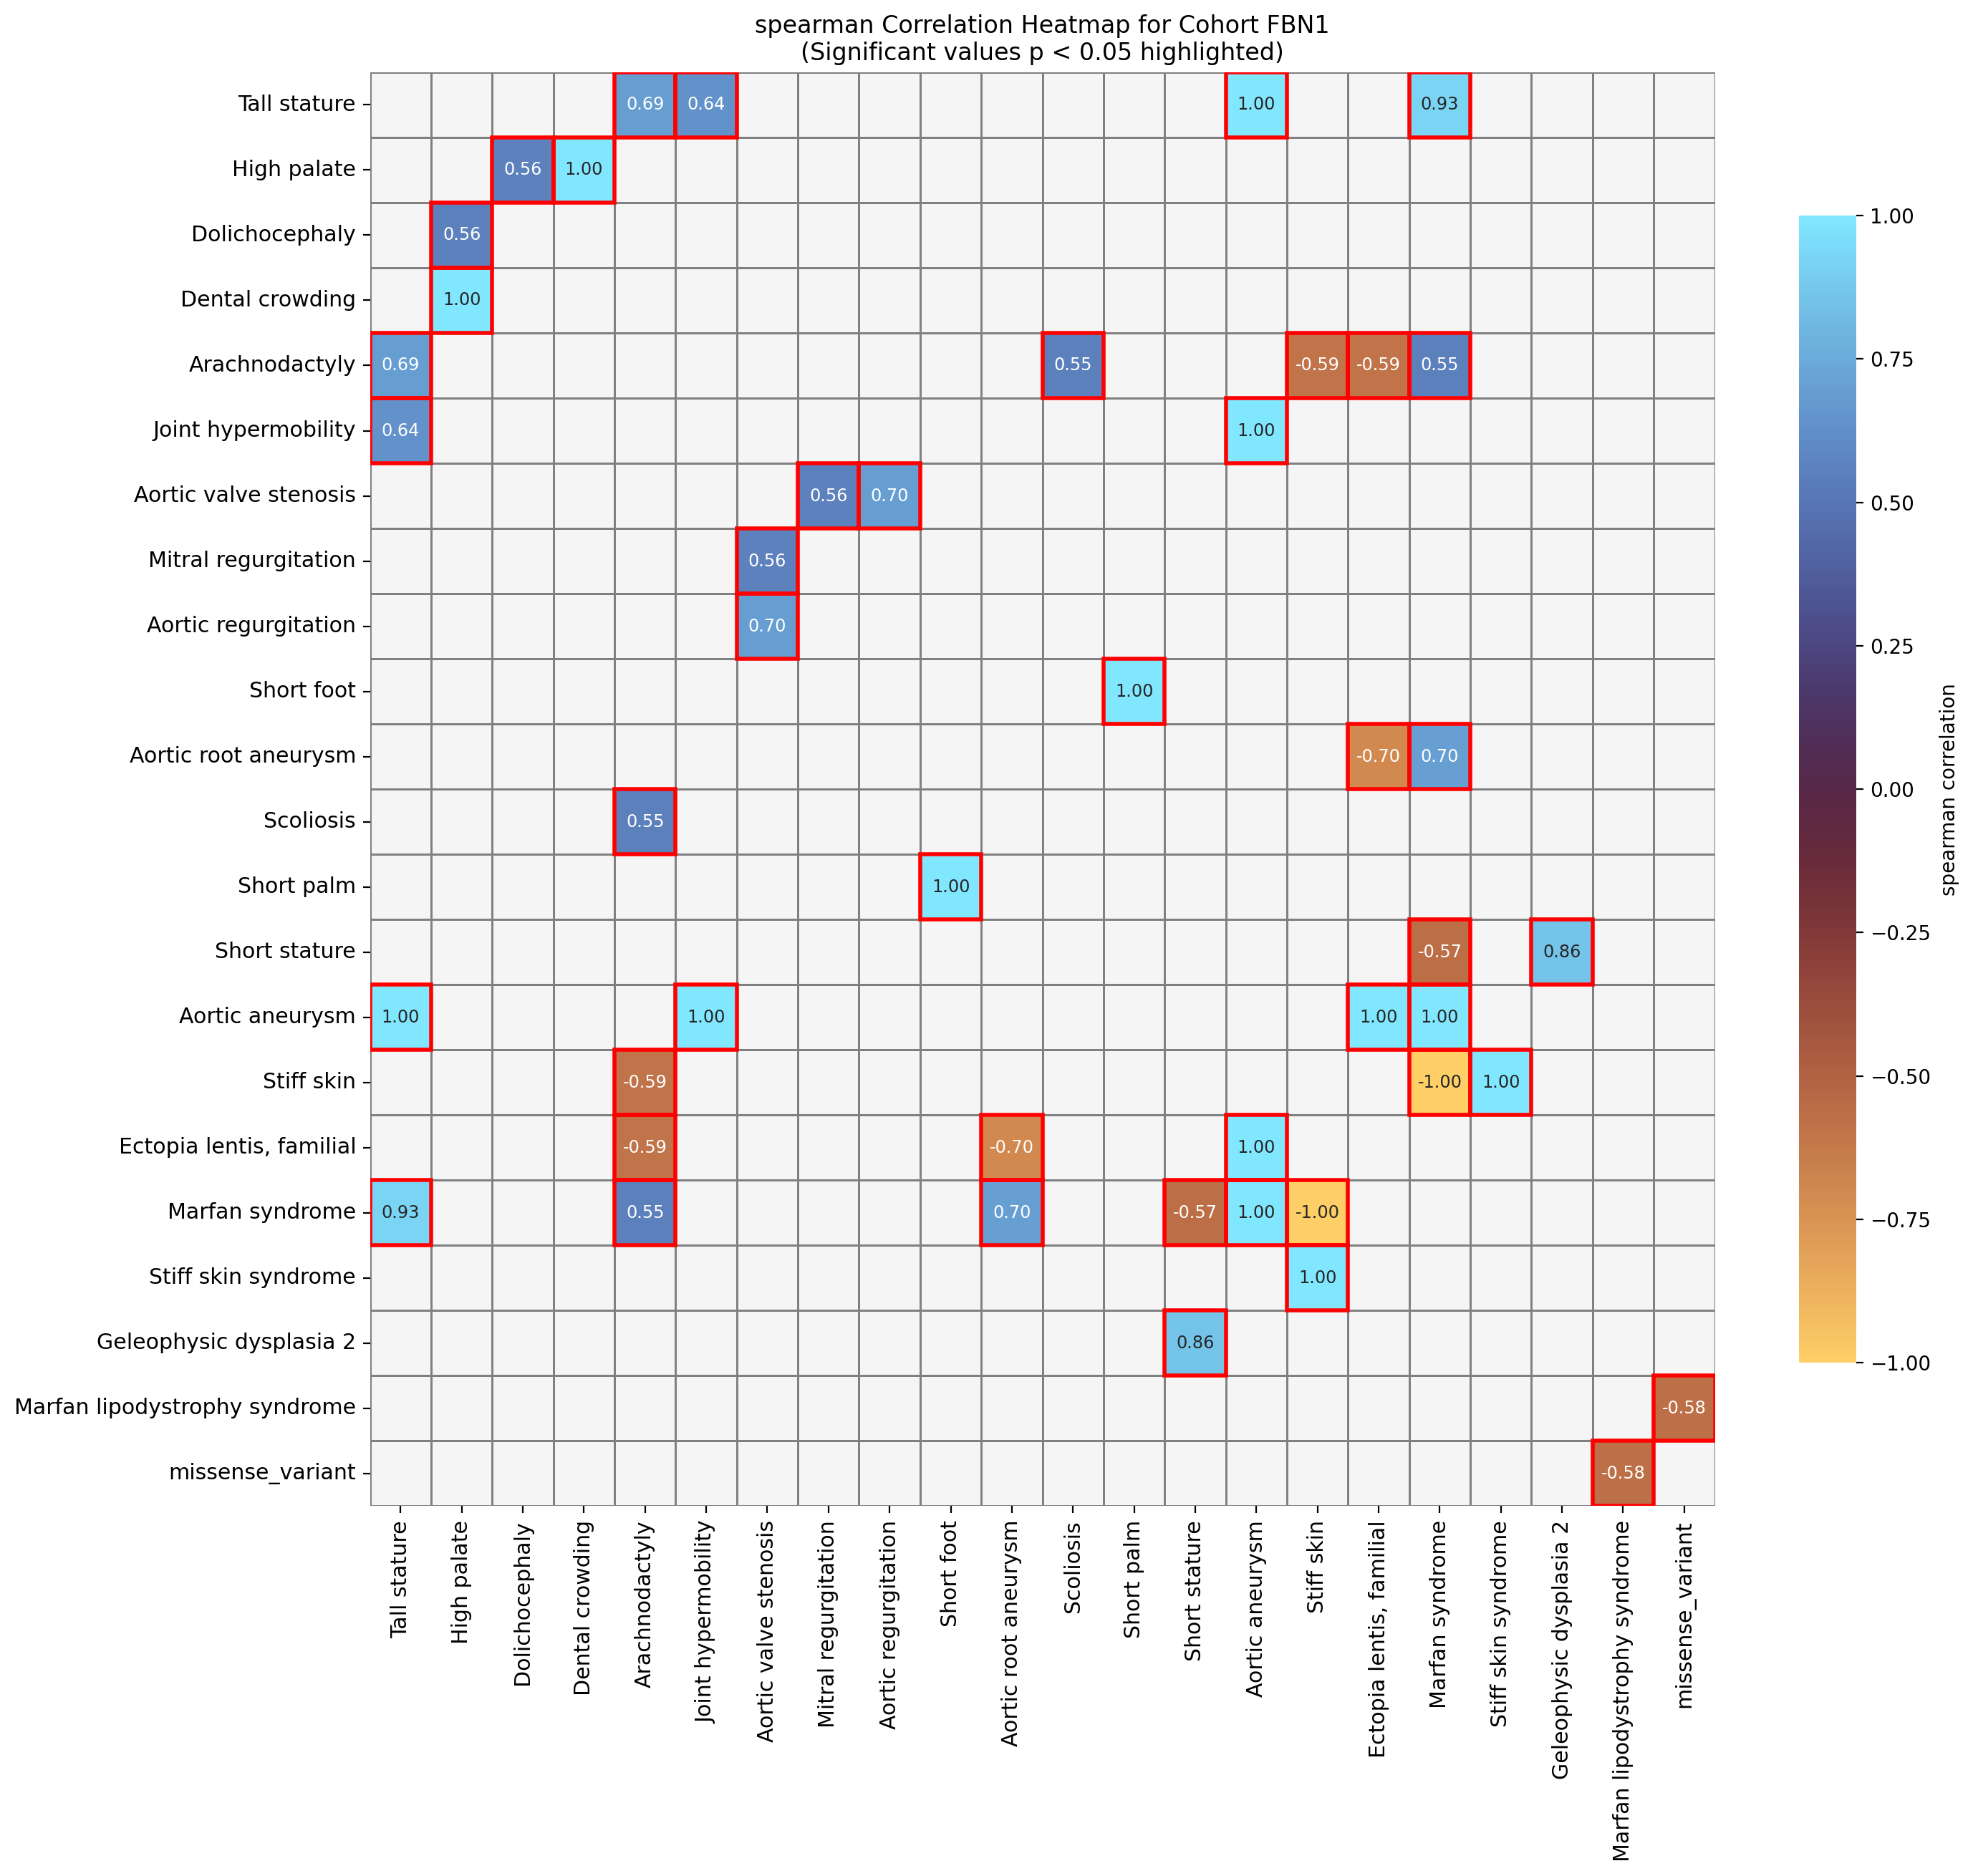

In [3]:
correlation_type = "spearman"  # Can be "kendall", "phi"
analyzer = HPOStatisticsAnalyzer(
    hpo_data = hpo_matrix,
    target_matrix = target_matrix,
    min_individuals_for_correlation_test=30)

coef_matrix, pval_matrix = analyzer.compute_correlation_matrix(
    stats_name=correlation_type,
    n_jobs=32)

analyzer.plot_correlation_heatmap_with_significance(
    correlation_type,
    lower_bound=-0.55,
    upper_bound=0.55,
    significance_threshold=0.05,
    title_name=f"Cohort {cohort_name}")

### **Analysis of Correlation for Terms Across Multiple Cohorts**

This section demonstrates how to perform correlation analysis for HPO terms, disease status, sex, and variant effects across multiple cohorts.

---

##### **Loading Data and Preparing HPO Matrices**

In [4]:
multi_cohort_names = ["TGFBR1","TGFBR2","SMAD3","TGFB2","TGFB3","SMAD2"]
multi_mane_tx_ids = ['NM_004612.4','NM_003242.6','NM_005902.4','NM_003238.6','NM_003239.5','NM_005901.6']
multi_varsiant_effect_type = VariantEffect.MISSENSE_VARIANT

# Load phenopackets from multiple cohorts
multi_phenopackets = CohortDataLoader.from_ppkt_store(cohort_name=multi_cohort_names)

# Prepare HPO and target matrices for multiple cohorts
multi_hpo_matrix, multi_target_matrix = PhenopacketMatrixProcessor.prepare_hpo_data(
    multi_phenopackets,
    variant_effect_type=multi_varsiant_effect_type,
    mane_tx_id=multi_mane_tx_ids,
    threshold=0,
    mode=None,
    use_label=True,
    nan_strategy=None
)

Individuals Processed: 100%|██████████| 277/277 [00:07<00:00, 38.53 individuals/s]


##### **Analysusing Data and Ploting the Heatmap**

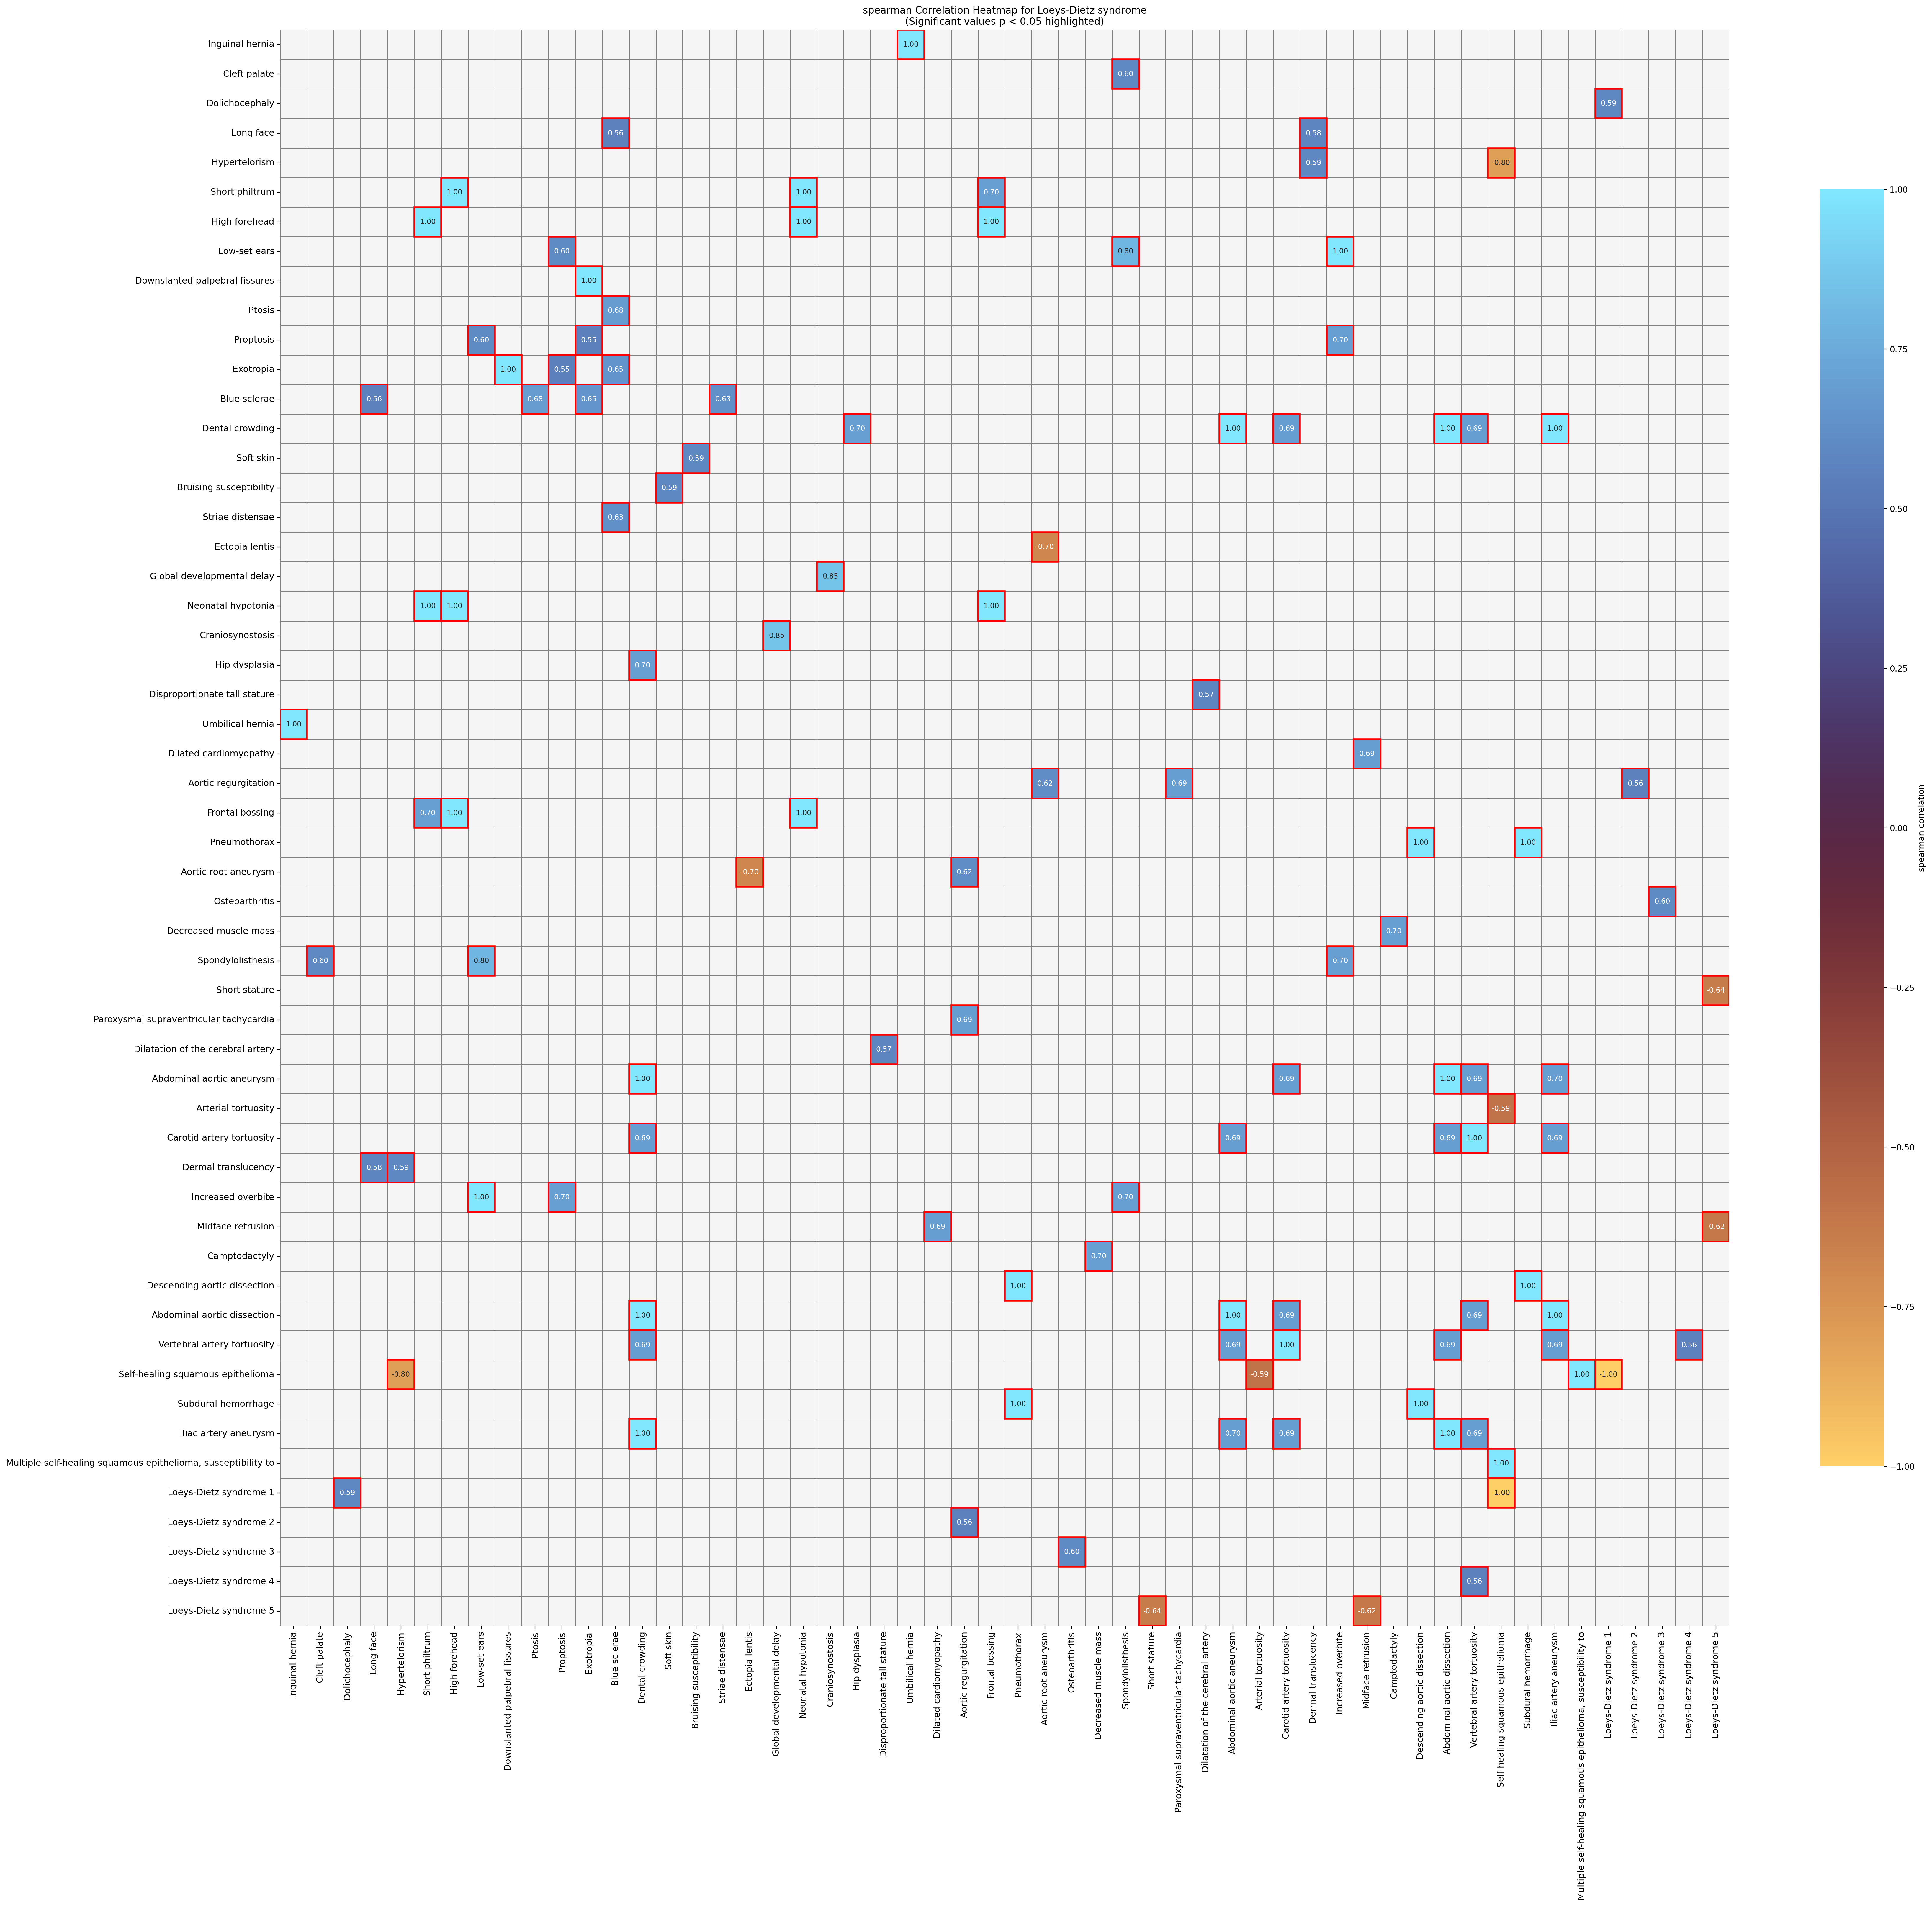

In [5]:
correlation_type = "spearman"

# Initialize analyzer for multiple cohorts
multi_analyzer = HPOStatisticsAnalyzer(
    multi_hpo_matrix, 
    multi_target_matrix,
    min_individuals_for_correlation_test=30
)

# Compute correlation
multi_coef_matrix, multi_pval_matrix = multi_analyzer.compute_correlation_matrix(correlation_type, n_jobs=32)

# Plot heatmap
multi_analyzer.plot_correlation_heatmap_with_significance(
    correlation_type,
    lower_bound=-0.55,
    upper_bound=0.55,
    significance_threshold=0.05,
    title_name='Loeys-Dietz syndrome')

### **Comprehensive Correlation Analysis Across All Cohorts in Phenopacket Store**
This section demonstrates how to perform correlation analysis for HPO terms, disease status, sex, and variant effects across all cohorts stored in the Phenopacket Store. It includes loading phenopacket data, preparing HPO matrices and disease target vectors, and performing pairwise correlation analyses between these factors across all available cohorts. This approach enables a comprehensive analysis across multiple datasets, providing insights into the relationships between HPO terms and disease-related factors.

---

##### **Extracting Phenopackets and Creating a Target Matrix for Multiple Cohorts**
The following demonstrates how to extract phenopackets for multiple target cohorts and create a binary target matrix indicating the presence of these cohorts.

In [6]:
from pathlib import Path
import zipfile
from ppktstore.model import PhenopacketStore
import pandas as pd

target_cohort_names = ['FBN1'] 
current_dir = Path().resolve()
ppkt_zip_path = current_dir.parent.parent / "tests" / "data" / "all_phenopackets.zip"

with zipfile.ZipFile(ppkt_zip_path) as zf:
    store = PhenopacketStore.from_release_zip(zf)

target_ppkts = []
for name in target_cohort_names:
    target_ppkts.extend(store.cohort_for_name(name).iter_phenopackets())

non_target_cohorts = {name: cohort for name, cohort in store._cohorts.items() if name not in target_cohort_names}
non_target_ppkts = [ppkt for cohort in non_target_cohorts.values() for ppkt in cohort.iter_phenopackets()]

all_ppkts = target_ppkts + non_target_ppkts
external_target_matrix = pd.DataFrame(
    data=[1]*len(target_ppkts) + [0]*len(non_target_ppkts),
    index=[ppkt.id for ppkt in all_ppkts],
    columns=[f"is_{'_'.join(target_cohort_names)}"])

##### **Loading Data and Preparing HPO Matrices**

In [7]:
all_hpo_matrix, all_target_matrix = PhenopacketMatrixProcessor.prepare_hpo_data(
    phenopackets=all_ppkts, 
    external_target_matrix=external_target_matrix, 
    threshold=0, 
    mode=None, 
    use_label=True,
    nan_strategy=None
)

target_hpo_matrix, target_target_matrix = PhenopacketMatrixProcessor.prepare_hpo_data(
    phenopackets=target_ppkts, 
    external_target_matrix=external_target_matrix, 
    threshold=0, 
    mode=None, 
    use_label=True,
    nan_strategy=None
)

common_columns = all_hpo_matrix[0].columns.intersection(target_hpo_matrix[0].columns)

all_hpo_matrix_filtered = all_hpo_matrix[0][common_columns]

In [9]:
all_target_matrix.columns

Index(['Apert syndrome', 'Acromicric dysplasia', 'Hajdu-Cheney syndrome',
       'Severe combined immunodeficiency due to ADA deficiency',
       'Tietz albinism-deafness syndrome', 'Pseudohypoparathyroidism Ia',
       'Amelogenesis imperfecta, type IA', 'Amyloidosis, Finnish type',
       'Amyotrophic lateral sclerosis 1', 'Diamond-Blackfan anemia 1',
       ...
       'Ovarian dysgenesis 11',
       'Immunodeficiency 123 with HPV-related verrucosis',
       'Polycystic kidney disease 8',
       'Spastic paraplegia 93, autosomal recessive',
       'Intellectual developmental disorder, autosomal dominant 75',
       'Spermatogenic failure 96', 'Premature ovarian failure 25',
       'Basal ganglia calcification, idiopathic, 10, autosomal recessive',
       'sex', 'is_FBN1'],
      dtype='object', length=518)

##### **Analysusing Data and Ploting the Heatmap**

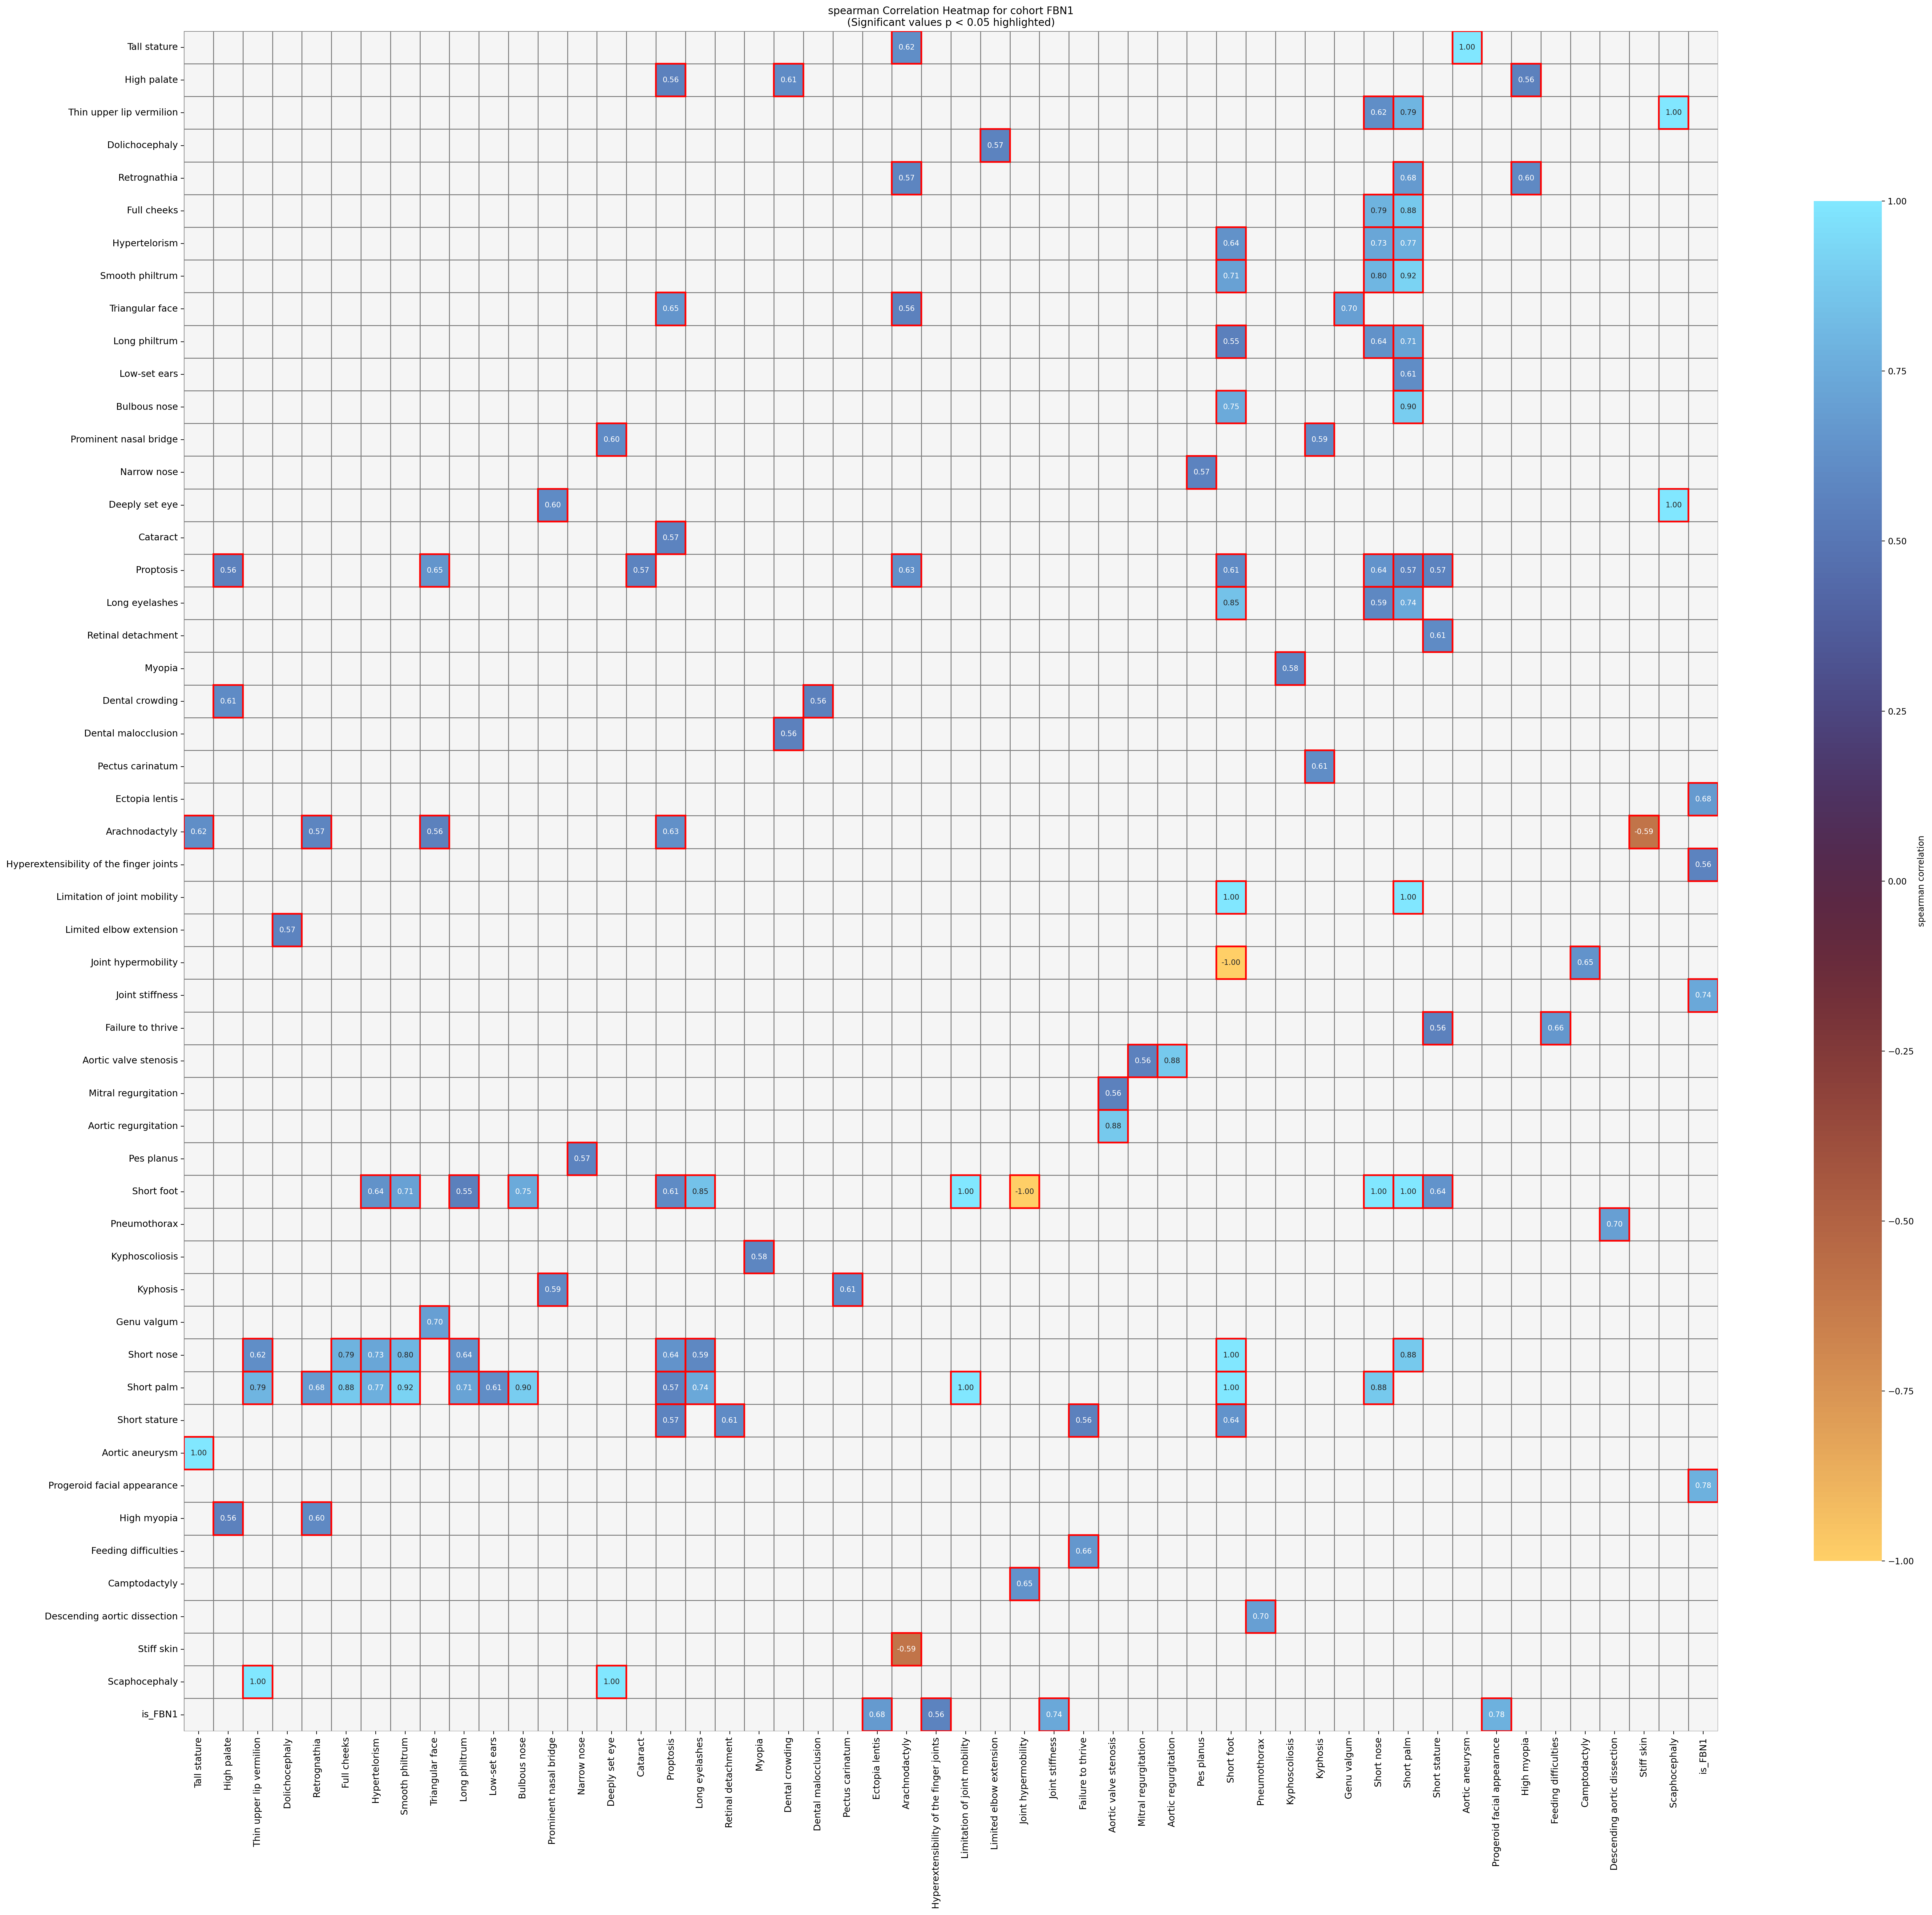

In [11]:
correlation_type = "spearman"
all_target=all_target_matrix[['is_FBN1']]
# Initialize the HPO statistics analyzer with the filtered HPO matrix and target matrix
hpo_analyzer = HPOStatisticsAnalyzer(
    (all_hpo_matrix_filtered,target_hpo_matrix[1]), 
    all_target, 
    min_individuals_for_correlation_test=30)

# Compute the correlation and p-value matrices using Spearman correlation
correlation_matrix, p_value_matrix = hpo_analyzer.compute_correlation_matrix(correlation_type, n_jobs=32)

# Plot the correlation heatmap with significance markers
hpo_analyzer.plot_correlation_heatmap_with_significance(
    correlation_type,
    lower_bound=-0.55,
    upper_bound=0.55,
    significance_threshold=0.05,
    title_name="cohort FBN1" 
)